In [1]:
import meep as mp
import meep.adjoint as mpa
from meep import Animate2D
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from meep.materials import Ag
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import matplotlib.colors as mcolors

mp.verbosity(0)
TiO2 = mp.Medium(index=2.6)
SiO2 = mp.Medium(index=1.44)
Si = mp.Medium(index=3.4)
Air = mp.Medium(index=1)

In [2]:
resolution = 100
design_region_resolution = int(resolution)

design_region_x_width  = 1   #100 nm
design_region_y_height = 1   #100 nm
design_region_z_height = 0.03  #20 nm or 10nm

pml_size = 1.0
pml_layers = [mp.PML(pml_size,direction=mp.Z)]

Sz_size = 0.6
Sx = design_region_x_width
Sy = design_region_y_height 
Sz = 2 * pml_size + design_region_z_height + Sz_size
cell_size = mp.Vector3(Sx, Sy, Sz)

wavelengths = np.array([1.55])     # wavelengths = np.array([1.5 ,1.55, 1.6])
frequencies = np.array([1 / 1.55])

nf = 1                 #3 #wavelengths Number

minimum_length = 0.01  # minimum length scale (microns)
eta_i = 0.5            # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55           # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e      # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

Source_distance = -0.2

fcen   = 1 / 1.55
width  = 0.2  
fwidth = width * fcen
source_center = mp.Vector3(0,0,Source_distance)  
source_size   = mp.Vector3(design_region_x_width, design_region_y_height, 0)
src    = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ey, size=source_size, center=source_center)]   

Nx = int(design_region_resolution * design_region_x_width) + 1
Ny = int(design_region_resolution * design_region_y_height) + 1
Nz = 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), Air, Ag, grid_type="U_MEAN")
design_region    = mpa.DesignRegion(
            design_variables,
            volume=mp.Volume(
            center=mp.Vector3(0,0,0),
            size=mp.Vector3(design_region_x_width, design_region_y_height, design_region_z_height),
            ),
)

def mapping(x, eta, beta):
    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_x_width,
        design_region_y_height,
        design_region_resolution,
    )
    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)
    projected_field = (npa.fliplr(projected_field) + projected_field) / 2
    projected_field = (npa.flipud(projected_field) + projected_field) / 2  # left-right symmetry    
    
    return projected_field.flatten()


geometry = [mp.Block(center=design_region.center, size=design_region.size, material=design_variables)]

kpoint = mp.Vector3()  # Periodic Boundary
sim = mp.Simulation(
    cell_size        = cell_size,
    boundary_layers  = pml_layers,
    geometry         = geometry,
    sources          = source,
    default_material = Air,
    k_point          = kpoint,
    symmetries       = [mp.Mirror(direction=mp.X)], 
    resolution       = resolution,
    extra_materials  = [Ag],       # Introducing metal complex terms
)
#---------------------------------------------------------------------------------------------------#


#-----------------[4]---------------------------------#
monitor_position   = mp.Vector3(0, 0, 0)       # Focus position
monitor_size       = mp.Vector3(0.01,0.01,0.01)     # Focus Size//////0.11
FourierFields_x    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ex,yee_grid=False)
FourierFields_y    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ey,yee_grid=False)
FourierFields_z    = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=False)
ob_list            = [FourierFields_x,FourierFields_y,FourierFields_z]


def J(fields_x,fields_y,fields_z):
    ET_x = npa.abs(fields_x) ** 2
    ET_y = npa.abs(fields_y) ** 2
    ET_z = npa.abs(fields_z) ** 2
    ET = npa.sqrt( npa.mean(ET_x) + npa.mean(ET_y) + npa.mean(ET_z) )  
    return ET


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decimation_factor = 1 ,           # KEY BUG!!
    maximum_run_time=50,
)

In [4]:
evaluation_history = np.load('Post_evaluation_history.npy')
beta_A  = np.load("Post_beta_scale_array.npy")
eta_A   = np.load("Post_eta_i_array.npy")
cur_A   = np.load("Post_cur_beta_array.npy")
x_A     = np.load("Post_x_array.npy")

Text(0, 0.5, 'FOM')

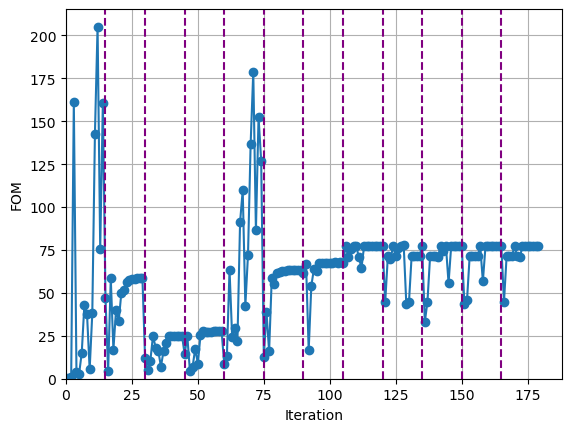

In [5]:
plt.figure()
plt.plot(evaluation_history, "o-")

for i in range(1,12):
    plt.axvline(x=15*i, color='purple', linestyle='--', label='x=3')
plt.grid(True)
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Iteration")
plt.ylabel("FOM")

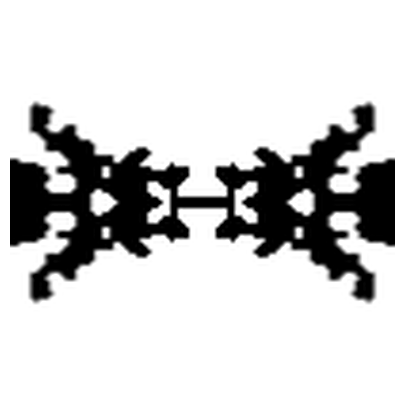

In [6]:
opt.update_design([mapping(x_A, eta_A, cur_A/beta_A)])  # cur_beta/beta_scale is the final beta in the optimization.
plt.figure(figsize=(5,5))
ax = plt.gca()
opt.plot2D(
    False,
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
    output_plane = mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(design_region_x_width, design_region_y_height, 0))
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()
plt.close()

In [7]:
opt.sim = mp.Simulation(
    cell_size=mp.Vector3(Sx, Sy ,Sz),
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point=kpoint,
    #symmetries=[mp.Mirror(direction=mp.X)],
    extra_materials = [Ag],
)
#src = mp.ContinuousSource(frequency=frequencies[0], fwidth=0.01 ,is_integrated=True)
src = [
    mp.Source(
        src=mp.GaussianSource(frequencies, fwidth=fwidth),
        component=mp.Ey,
        size=mp.Vector3(0,0,0),
        center=mp.Vector3(0,0,0),
    )
]

opt.sim.change_sources(src)

ex0_data =[] # no structure
ey0_data =[] # no structure
ez0_data =[] # no structure
time0_data = [] # no structure

ex_data =[] 
ey_data =[] 
ez_data =[] 
time_data = []




def collect_ey(sim):
    ex = sim.get_field_point(mp.Ex, mp.Vector3(0,0,0))
    ey = sim.get_field_point(mp.Ey, mp.Vector3(0,0,0))
    ez = sim.get_field_point(mp.Ez, mp.Vector3(0,0,0))
    ex_data.append(ex)
    ey_data.append(ey)
    ez_data.append(ez)
    time0_data.append(sim.meep_time())

opt.sim.run(
    mp.after_time(0, mp.at_every(1 / resolution, lambda sim: collect_ey(sim))),
    until=100
)

FloatProgress(value=0.0, description='0% done ')

(10000,)
(10000,)


/home/ming/anaconda3/envs/mp/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


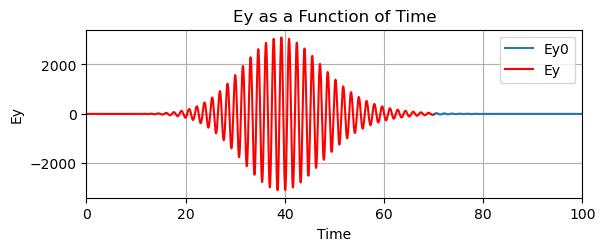

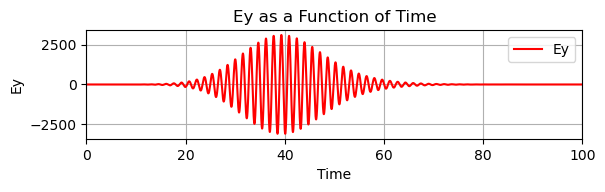

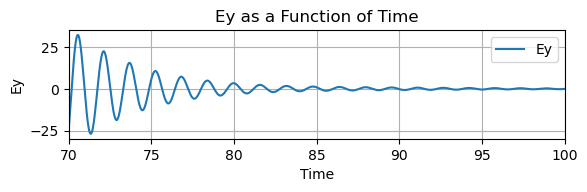

Ey and time data saved to: ey_time_data.txt


In [8]:
ey_data = np.array(ey_data)
time_data = np.array(time0_data)
print(ey_data.shape)
print(time_data.shape)

# Plot Ey vs. time
#ey0_re = np.real(ey0_data)
#y0 = np.sign(ey0_re) * np.abs(ey0_re)**0.5  
ey_re = np.real(ey_data)
y = np.sign(ey_re) * np.abs(ey_re)**0.5  
plt.subplot(2,1,1)
plt.plot(time_data[7000:10000], ey_data[7000:10000] ,'-' ,label='Ey0')
plt.plot(time_data[0:7000], ey_data[0:7000] , 'r',label='Ey')
plt.xlabel('Time')
plt.ylabel('Ey')
plt.title('Ey as a Function of Time')
#plt.yscale('symlog')
plt.legend()
plt.xlim([0,100])
plt.grid(True)
plt.show()
plt.close()

plt.subplot(3,1,2)
plt.plot(time_data, ey_re,'r', label='Ey')
plt.title('Ey as a Function of Time')
plt.xlabel('Time')
plt.ylabel('Ey')
plt.legend()
plt.xlim([0,100])
plt.grid(True)
plt.show()
plt.close()


plt.subplot(3,1,3)
plt.plot(time_data[7000:10000], ey_re[7000:10000],'-', label='Ey')
plt.title('Ey as a Function of Time')
plt.xlabel('Time')
plt.ylabel('Ey')
plt.legend()
plt.xlim([70,100])
plt.grid(True)
plt.show()
plt.close()

# Save the time and Ey data to a file
filename = "ey_time_data.txt"
with open(filename, "w") as f:
    for t, ey in zip(time_data[7000:10000], ey_data[7000:10000]):
        f.write(f"{ey.real}+{ey.imag}i\n") # Save time, Ey

print(f"Ey and time data saved to: {filename}")

In [9]:
import os
## !! set  -t 1/resolution, since mp.after_time(10,mp.at_every(1/resolution, collect_ey))
cmd_str1 = f"OMP_NUM_THREADS=1 harminv -t {1/resolution}  0.6-0.7 < ey_time_data.txt" 
os.system(cmd_str1)

frequency, decay constant, Q, amplitude, phase, error
0.642449, 1.778511e-01, 11.3483, 21.731, 2.81039, 1.979048e-04
0.655246, 1.682217e-01, 12.2369, 11.4034, 0.65376, 3.215201e-04


0